### Imports

In [23]:
import ultralytics
from ultralytics import YOLO
import os
import math
from PIL import Image
import cv2
from IPython.display import Video
import glob
import matplotlib.pyplot as plt
import numpy as np

import board.corners as corners
import board.grid as grid
import board.pieces as pieces

import warnings
warnings.filterwarnings("ignore")

### Load picture and Models

In [24]:
# Image
img_path = 'images/test_images/img_3.jpg'
loaded_img = cv2.imread(img_path)
# to RGB
loaded_img = cv2.cvtColor(loaded_img, cv2.COLOR_BGR2RGB)

# Models
corners_model_path = 'models/corners.pt'
grid_model_path = 'models/segment_grid.pt'
pieces_model_path = 'models/pieces_large.pt'

corners_model = YOLO(corners_model_path)
grid_model = YOLO(grid_model_path)
pieces_model = YOLO(pieces_model_path)

print('Models loaded')

Models loaded


### Detect 4 corners of the board

In [25]:
results = corners.predict_corners(corners_model, loaded_img, confidence_threshold=0.25, iou_threshold=0.1)

# image_corners = results[0].plot(line_width=7, font_size=15)
# image_corners = cv2.cvtColor(image_corners, cv2.COLOR_BGR2RGB) # convert image back to rgb
# plt.imshow(image_corners)
# plt.show()


0: 640x480 4 corners, 23.8ms
Speed: 9.1ms preprocess, 23.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Using these 4 corners, we:
1. Add some margins so all the pieces can be detected
2. Transform the image based on these 4 coordinates of the corners with added margins

In [26]:
corners4 = corners.get_corner_coordinates(results)

# Sort corners
labeled_corners, sorted_corners = corners.label_and_sort_corners(corners4)
if labeled_corners is None or sorted_corners is None:
    print("Could not find all corners")
    exit()
print("Corners: ", sorted_corners)
# Add offset to corners
sorted_corners = corners.add_offset(sorted_corners, offsetx=300, offsety=300)

print("Sorted corners with offset: ", sorted_corners)


Corners:  [(921.81274, 926.7477), (2399.3853, 797.66693), (2692.675, 2505.6536), (382.65237, 2518.359)]
Sorted corners with offset:  [(621.812744140625, 626.7476806640625), (2699.38525390625, 497.66693115234375), (2992.675048828125, 2805.653564453125), (82.65237426757812, 2818.35888671875)]


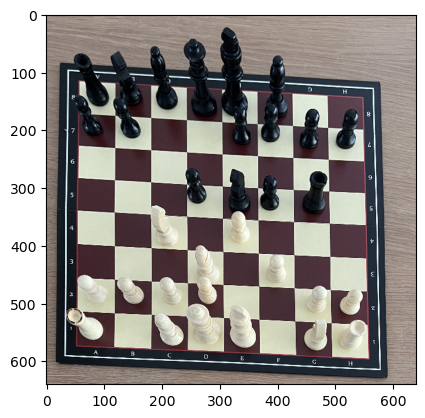

In [27]:
# load image
image = cv2.imread(img_path)

# transform image
transformed_image = corners.transform_image_corners(image, sorted_corners)
transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) # convert image back to rgb


# Display transformed image
plt.imshow(transformed_image)
plt.show()


### Grid Detection and Defining 

In [28]:
grid_prediction = grid.predict_grid_segmentation(grid_model, transformed_image)
grid_corners = grid.get_corners_from_grid_segmentation(grid_prediction)

# grid_image = grid_prediction[0].plot(line_width=1, font_size=20)
# grid_image = cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB) # convert image back to rgb
# plt.imshow(grid_image)
# plt.show()



0: 640x640 1 board-8fSi, 27.2ms
Speed: 6.0ms preprocess, 27.2ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 640)
gets here


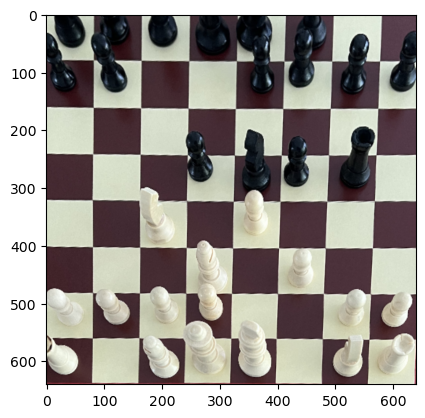

In [29]:
transformed_grid, transformation = grid.make_perspective_transform(transformed_image, grid_corners)

# Show transformed grid
plt.imshow(transformed_grid)
plt.show()




Grid Orientation

In [30]:
# ...

### Piece detection:
1. Detecting Pieces
2. Mapping pieces to grid


0: 640x640 2 black_bisshops, 1 black_king, 2 black_knights, 8 black_pawns, 1 black_queen, 2 black_rooks, 2 white_bisshops, 1 white_king, 2 white_knights, 8 white_pawns, 1 white_queen, 2 white_rooks, 38.0ms
Speed: 4.0ms preprocess, 38.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Detected pieces:  [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'black_bisshop', 1: 'black_king', 2: 'black_knight', 3: 'black_pawn', 4: 'black_queen', 5: 'black_rook', 6: 'white_bisshop', 7: 'white_king', 8: 'white_knight', 9: 'white_pawn', 10: 'white_queen', 11: 'white_rook'}
obb: None
orig_img: array([[[153, 139, 130],
        [150, 136, 127],
        [155, 141, 132],
        ...,
        [182, 171, 165],
        [182, 171, 165],
        [179, 168, 162]],

       [[154, 140, 131],
        [157, 143, 134],
        [149, 135, 126],
        ...,
        [187, 176, 170],
        [178, 167

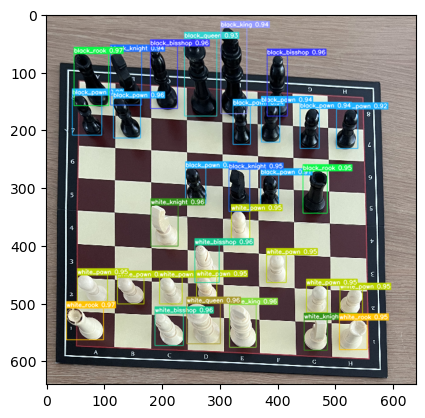

In [31]:
detected_pieces = pieces.detect_pieces(pieces_model, transformed_image)
print("Detected pieces: ", detected_pieces)
labels = detected_pieces[0].boxes.cls
print("Labels: ", labels)

img = detected_pieces[0].plot(line_width=1, font_size=10)
plt.imshow(img)
plt.show()

In [32]:
boxes, labels = pieces.extract_boxes_labels(detected_pieces)
sampled_points = pieces.get_sampled_points(boxes, labels, num_points=10)

mapped_pieces = pieces.get_mapped_pieces(sampled_points, transformation)
print("Mapped pieces: ", mapped_pieces)
fen_notation = pieces.create_FEN_notation(mapped_pieces)
print("FEN notation: ", fen_notation)


Mapped pieces:  [('A1', 'R'), ('A8', 'r'), ('D1', 'Q'), ('F8', 'b'), ('C4', 'N'), ('E1', 'K'), ('C8', 'b'), ('B7', 'p'), ('D3', 'B'), ('C1', 'B'), ('G5', 'r'), ('A2', 'P'), ('D2', 'P'), ('H1', 'R'), ('F3', 'P'), ('E5', 'n'), ('D5', 'p'), ('C2', 'P'), ('E4', 'P'), ('G1', 'N'), ('B2', 'P'), ('G2', 'P'), ('H2', 'P'), ('B8', 'n'), ('F7', 'p'), ('E7', 'p'), ('E8', 'k'), ('G7', 'p'), ('D8', 'q'), ('A7', 'p'), ('H7', 'p'), ('F5', 'p')]
Position: A1, Piece: R
Position: A8, Piece: r
Position: D1, Piece: Q
Position: F8, Piece: b
Position: C4, Piece: N
Position: E1, Piece: K
Position: C8, Piece: b
Position: B7, Piece: p
Position: D3, Piece: B
Position: C1, Piece: B
Position: G5, Piece: r
Position: A2, Piece: P
Position: D2, Piece: P
Position: H1, Piece: R
Position: F3, Piece: P
Position: E5, Piece: n
Position: D5, Piece: p
Position: C2, Piece: P
Position: E4, Piece: P
Position: G1, Piece: N
Position: B2, Piece: P
Position: G2, Piece: P
Position: H2, Piece: P
Position: B8, Piece: n
Position: F7, P

In [33]:
# def xyhw_to_xyxy(box):
#     # Somehow x and y in xywh are the center of the box
    
#     x, y, w, h = box
#     # Calculate top-left corner (x1, y1)
#     x1 = x - w / 2
#     y1 = y - h / 2
#     # Calculate bottom-right corner (x2, y2)
#     x2 = x + w / 2
#     y2 = y + h / 2
#     return [x1, y1, x2, y2]


# def draw_bboxes_on_image(image_path, boxes):
#     # Load the image
#     # image_bgr = cv2.imread(image_path)
#     # Iterate over each box to draw rectangles
#     for box in boxes:
#         x, y, w, h = box
#         # Calculate top-left corner (x1, y1)
#         x1 = x - w / 2
#         y1 = y - h / 2
#         # Calculate bottom-right corner (x2, y2)
#         x2 = x + w / 2
#         y2 = y + h / 2
#         # Draw a rectangles based on top-left and bottom-right corners
#         cv2.rectangle(image_path, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        
#     # Show the image with boxes
#     cv2.imshow("Detected Pieces with Bounding Boxes", image_path)
#     cv2.waitKey(0)  # Wait for a key press to close the displayed window
#     cv2.destroyAllWindows()

# # Extracting boxes from the results
# def extract_boxes(results):
#     # Assuming results.boxes returns a tensor of boxes in format [x, y, w, h]
#     boxes = results[0].boxes
#     bboxes = boxes.xywh
#     labels = results[0].boxes.cls
#     llabels = labels.cpu().numpy()
#     # return bboxes, llabels
#     return bboxes.cpu().numpy()

# # Example usage
# # image_path = '/path/to/your/image.png'
# boxes = extract_boxes(detected_pieces)

# draw_bboxes_on_image(transformed_image, boxes)